# "Remaining Useful Life Estimation in Prognostics Using Deep Convolution Neural Networks" by Xiang Li et al.

This document reproduces the implementation of a Deep Convolutional Network  by Xiang Li et al. applied to the NASA "CMAPSS" dataset. This implementation has been done in Keras.

Copyright (c) by Manuel Arias, Christian Schneebeli and Lukas R. Peter 2017-12-01.

Before jumping into the problem, let's run the cell below to load the required packages.

In [1]:
import os
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Add
from keras.layers import Dropout
from keras.models import Model
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.initializers import glorot_uniform
from keras import optimizers
from IPython.display import SVG, clear_output
from keras.utils import plot_model
from os import path

import pandas
from pandas.plotting import scatter_matrix
import seaborn as sns

import keras.callbacks
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# 1  "CMAPSS" Dataset

The proposed method is evaluated on a prognostic benchmarking problem, i.e. NASA’s turbofan engine degradation problem [30, 41]. This popular dataset contains simulated data produced by a model-based simulation program, i.e. Commercial Modular
Aero-Propulsion System Simulation (C-MAPSS), which was developed by NASA. The CMAPSS dataset includes 4 sub-datasets that are composed of multi-variate temporal data obtained from 21 sensors. Each sub-dataset contains one training set and one test set. The training datasets include run-to-failure sensor records of multiple aero-engines collected under different operational conditions and fault modes. Each engine unit starts with different degrees of initial wear and manufacturing variation that is unknown and considered to be healthy. As time progresses, the engine units begin to degrade until they reach the system failures, i.e. the last data entry corresponds to the time cycle that the engine unit is declared
unhealthy. On the other hand, the sensor records in the testing datasets terminate at some time before system failure, and the goal of this task is to estimate the remaining useful life of each engine in the test dataset. For verification, the actual RUL value for the testing engine units are also provided. In this study, a comprehensive evaluation of the proposed method is carried out on all the four sub-datasets.


**Details of the "CMAPSS" dataset**
- Training: 17731 inputs from 100 engine trajectories. It uses a sliding time window of 30 time stamps. 
- Test: 100 points from 100 engine trajectories. It takes the last available 30 time stamps.

# 1.1  Data Pre-processing

In the training process, all the available engine measurement data points are used as the training samples, and each data point is associated with its RUL label as the target. A piecewise linear degradation model [5] is used to obtain the RUL label with respect to each training sample. During testing, the one data point corresponding with the last recorded
cycle for each engine unit is generally used as the testing sample. The actual RUL of the testing samples are provided in the dataset.

The multi-variate temporal data in the C-MAPSS dataset contains engine unit measurements from 21 sensors [30]. However, some sensor readings have constant outputs in the engine’s lifetime and they do not provide valuable information for RUL estimation. Therefore, 14 sensor measurements out of the total 21 sensors are used as the raw input features as did in
the literature [5, 29], whose indices are 2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20 and 21.

For each of the 4 sub-datasets in C-MAPSS, the collected measurement data from each sensor are normalized to be within the range of [−1, 1] using the min-max normalization method.

## 1.1.1  Time window processing
In the multi-variate time series-based problems such as $RUL$ estimation, more information can be generally obtained from the temporal sequence data compared with the multi-variate data point sampled at a single time step. In this paper, a time window is adopted for the data preparation to use the multi-variate temporal information. Let $N_{tw}$ denote the size of the time window. At each time step, all the past sensor data within the time window for each  engine unit are collected to form a high-dimensional feature vector, and used as the inputs for the network.

**Time window details**
- $N_{tw} = 30$ 
- Stride = 1

## 1.1.2  R early
In general, the engine unit works normally in the early age and degrades afterwards. It is assumed to have a constant RUL label in the initial period. Following the recent researches in the literature [2,5,42] , $R_{early}$ which is a constant RUL value, is used as the target labels for the data points in the early period. It should be noted that $R_{early}$ has noticeable effect on the prognostic performance on the dataset.

In [3]:
N_tw     = 30                                                               # Time Window (N_tw)
R_early  = 125                                                              # Max RUL in training set
stride   = 1
sel      = np.array([6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 21, 24, 25])  # Index of input features

In [4]:
def sliding_window(data, N_tw = 30, stride = 1):
    N_en = np.unique(data[:,0]).shape[0]                            # Number of engines (N_en)
    m = 0
    for i in range(N_en):
        n_H   = data[data[:,0] == i+1,0].shape[0]
        N_sw  = int((n_H- N_tw) / stride + 1)                       # Number of sliding windows for engine 'i' 
        for h in range(N_sw):
            m = m + 1    
    return m, N_en        

In [5]:
def load_dataset(N_tw, stride, sel, R_early):
    # Load training data
    basepath        = path.dirname(os.getcwd()) 
    train_set       = np.loadtxt(path.abspath(path.join(basepath, "data", "train_FD001.txt")))    # Training set
    train_set_x_org = train_set[:,sel]                              # Training set input space (x)    
    train_set_c     = train_set[:,np.array([1])]                    # Training set cycles (c)
 
    # Compute correlation of input data
    d = pandas.DataFrame(data = train_set_x_org)
    corrmat = d.corr()

    # Normalize the data
    ub = train_set_x_org.max(0)
    lb = train_set_x_org.min(0)    
    train_set_x = 2 * (train_set_x_org - lb) / (ub - lb) - 1   
   
    N_ft    = sel.shape[0]                                           # Nunber of features (N_ft)
    m, N_en = sliding_window(train_set, N_tw, stride)                # Number of training data & engines
    
    train_x = np.empty((m, N_tw, N_ft, 1), float)
    train_y = np.empty((m, 1), float)
    
    k = 0
    for i in range(N_en):
        idx       = train_set[:,0] == i+1                            # Index for engine number 'i'
        train_i_x = train_set_x[idx,:]                               # Engine 'i' training  data
        train_i_c = train_set_c[idx]                                 # Engine 'i' cycles (c)
        train_i_y = train_i_c[-1] - train_i_c                        # RUL: Remaining Useful Lifetime for engine 'i'
        train_i_y[train_i_y > R_early] = R_early                     # R_early = 125
        N_sw      = int((train_i_x.shape[0] - N_tw) / stride + 1)    # Number of sliding windows for engine 'i' 
        for h in range(N_sw):
            k = k + 1
            vert_start = h * stride
            vert_end   = h * stride + N_tw
            train_i_x_slice = train_i_x[vert_start:vert_end,:]       # Training input data for engine 'i' on time window 'h'
            train_i_y_slice = train_i_y[vert_end-1,:]                # Training output data for engine 'i' on time window 'h'
            train_i_x_slice.shape = (N_tw, N_ft, 1)                  # Reshape training set input (N_tw, N_ft, 1)
            train_i_y_slice.shape = (1, 1)                           # Reshape training set output (1, 1)
            train_x[k-1,:,:] = train_i_x_slice
            train_y[k-1,:] = train_i_y_slice
     
    # Load test data
    test_set       = np.loadtxt(path.abspath(path.join(basepath, "data", "test_FD001.txt")))
    test_set_x_org = test_set[:,sel]                                 # Test set input space (x)
    test_set_c     = test_set[:,np.array([1])]                       # Test set cycles (c)
    test_y         = np.loadtxt(path.abspath(path.join(basepath, "data", "RUL_FD001.txt")))   # Test set RUL (c)
    test_y.shape   = (test_y.shape[0], 1)
    
    # Normalize the data
    test_set_x = 2 * (test_set_x_org - lb) / (ub - lb) - 1   
    
    m_ts, N_en_ts = sliding_window(test_set, N_tw, stride)           # Number of training data & engines
    
    test_x = np.empty((N_en_ts, N_tw, N_ft, 1), float)
    
    k = 0
    for ii in range(N_en_ts):
        engine         = test_set[:,0] == ii+1                       # Index for engine number 'i'
        test_i_x       = test_set_x[engine,:]                        # Engine 'i' test  data
        test_i_x_slice = test_i_x[-N_tw:,:]                          # Training input data for engine 'i' on time window 'h'
        test_i_x_slice.shape = (N_tw, N_ft, 1)                       # Reshape training set input (N_tw, N_ft, 1)
        test_x[ii,:,:] = test_i_x_slice
    
    return train_x, train_y, test_x, test_y, corrmat

In [6]:
X_train, Y_train, X_test, Y_test, corrmat = load_dataset(N_tw, stride, sel, R_early)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 17731
number of test examples = 100
X_train shape: (17731, 30, 14, 1)
Y_train shape: (17731, 1)
X_test shape: (100, 30, 14, 1)
Y_test shape: (100, 1)


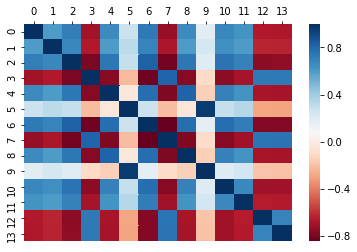

In [7]:
#scatter_matrix(d)
#plt.show()
sns.heatmap(corrmat, cmap="RdBu", square=False).xaxis.tick_top()  

In [8]:
# adapted from http://matplotlib.org/examples/specialty_plots/hinton_demo.html
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))

    ax.patch.set_facecolor('lightgray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'red' if w > 0 else 'blue'
        size = np.sqrt(np.abs(w))
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    nticks = matrix.shape[0]
    ax.xaxis.tick_top()
    ax.set_xticks(range(nticks))
    ax.set_xticklabels(list(matrix.columns), rotation=90)
    ax.set_yticks(range(nticks))
    ax.set_yticklabels(matrix.columns)
    ax.grid(False)

    ax.autoscale_view()
    ax.invert_yaxis()

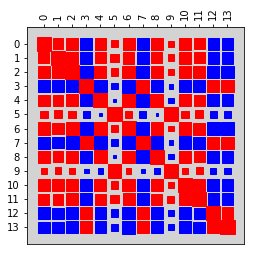

In [9]:
 hinton(corrmat)

# 2  Network Structure

In general, the proposed deep learning method consists of two sub-structures, i.e. multiple convolution neural networks and fully-connected layer for regression.

First, the input data sample is prepared in 2-dimensional (2D) format. The dimension of the input is $N_{tw} × N_{ft}$, where $N_{tw}$ denotes the time sequence dimension and $N_{ft}$ is the number of selected features (i.e. number of sensor measurements).

Next, 4 identical convolution layers are stacked in the network for feature extraction. The convolutions considers $F_N$ filters with kernel size $F_L × 1$. Zerospadding operation is implemented to keep the feature map dimension unchanged. Therefore, the obtained output feature maps dimension is $N_{tw} × N_{ft} × F_N$. We use another convolution layer with 1 filter to combine the previous feature maps to be a unique one. The filter size is $3 × 1$.

Afterwards, the 2-dimensional feature map is flattened and connected with a fully-connected layer. Note that dropout technique is used on the last feature map, i.e. the flattened layer, to relieve overfitting. Finally, one neuron is attached at the end of the proposed network for $RUL$ estimation.

**Model Hyperparameters:**


In [10]:
# Kernel size
kernels = [10, 10, 10, 10, 3]

# Number of filters (channels)
filters = [10, 10, 10, 10, 1]

# Activation
activ = 'tanh'

# 3  Model in Keras
Keras uses a different convention with variable names than TensorFlow. In particular, rather than creating and assigning a new variable on each step of forward propagation such as X, Z1, A1, Z2, A2, etc. for the computations for the different layers, in Keras code each line above just reassigns X to a new value using X = .... In other words, during each step of forward propagation, we are just writing the latest value in the commputation into the same variable X. The only exception was X_input, which we kept separate and did not overwrite, since we needed it at the end to create the Keras model instance (model = Model(inputs = X_input, ...) above).

In [11]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('tanh')(X)
   
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, 1), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('tanh')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('tanh')(X)
      
    return X

In [12]:
def convolutional_block(X, f, filters, stage, block, s = 1):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('tanh')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, 1), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('tanh')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)

    ### SHORTCUT PATH ###
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('tanh')(X)
       
    return X

In [13]:
def ResNetCNN_2d(input_shape, filters, kernels):
    """
    Implementation of the 1D_CNN model.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Retrieve Filters & kernels
    F0, F1, F2, F3, F4 = filters                 
    K0, K1, K2, K3, K4 = kernels    
      
    # Define the input placeholder as a tensor with shape input_shape    
    X_input = Input(input_shape)
   
    # CONV -> RELU Block applied to X_input
    X = Conv2D(F0, (K0, 1), strides = (1, 1), padding = 'same', activation = activ, kernel_initializer = glorot_uniform(seed=0), name = 'conv0')(X_input)
    
    # Stage 1
    X = convolutional_block(X, f = K1, filters = [F1, F2, F3], stage = 1, block='a', s = 1)
    X = identity_block(X, K2, [F1, F2, F3], stage = 1, block='b')
    X = identity_block(X, K3, [F1, F2, F3], stage = 1, block='c')
    X = identity_block(X, K3, [F1, F2, F3], stage = 1, block='d')
    
    # Stage 2
    X = convolutional_block(X, f = K1, filters = [F1, F2, F3], stage = 2, block='a', s = 1)
    X = identity_block(X, K2, [F1, F2, F3], stage = 2, block='b')
    X = identity_block(X, K3, [F1, F2, F3], stage = 2, block='c')
    X = identity_block(X, K3, [F1, F2, F3], stage = 2, block='d')
      
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(F4, (K4, 1), strides = (1, 1), padding = 'same', activation = activ, kernel_initializer = glorot_uniform(seed=0), name = 'conv4')(X)
    
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    X = Dense(100, activation = activ, name='fc')(X)
    X = Dense(1, name='RUL')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='ResNetCNN_2d')    
   
    return model

Now, we feed the model hyperparameters to the CNN model

In [14]:
# Call the model
ResNetCNN_2d = ResNetCNN_2d(X_train.shape[1:],filters, kernels)

## 3.1 Model Summary

In [15]:
ResNetCNN_2d.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 14, 1)    0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 30, 14, 10)   110         input_1[0][0]                    
__________________________________________________________________________________________________
res1a_branch2a (Conv2D)         (None, 30, 14, 10)   110         conv0[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 30, 14, 10)   0           res1a_branch2a[0][0]             
__________________________________________________________________________________________________
res1a_bran

## 3.2 Model Training

Its configuration is determined including the number of hidden layers, convolution filter number and length etc. The DCNN takes as the inputs the normalized training data, and the labeled RUL values for the training samples are used as the target outputs of the network

All the layers use tanh as the activation functions, and Xavier normal initializer is employed for the weight initializations [38]. Back-propagation learning is used for the updates of the weights in the network. The Adam optimization algorithm [40] is used with mini-batches for the updates. For each training epoch, the samples are randomly divided into multiple mini-batches with each batch containing 512 samples, and put into the training system. Next, the network information, i.e. the weights in each layer, are optimized based on the mean loss function of each mini-batch. It should be noted that the selection of batch size affects the network training performance [45]. The batch size of 512 samples is found appropriate based on the experiments and it is used in all the case studies in this paper. In addition, varying learning rate is adopted. For the first 200 epochs from the beginning, the learning rate is 0.001 for fast optimization. The learning rate of 0.0001 is used afterwards for stable convergence. The maximum number of the training epochs is 250.

In [16]:
ResNetCNN_2d.compile(optimizer = "Adam", loss = "mean_squared_error")

** Learning rate:**

In [17]:
print('Learning Rate: ' + str(K.get_value(ResNetCNN_2d.optimizer.lr)))

Learning Rate: 0.001


We define an updatable plot to track training evolution

In [ ]:
# updatable plot
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []        
        self.fig = plt.figure()        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, np.sqrt(self.losses), label="loss")
        plt.plot(self.x, np.sqrt(self.val_losses), label="val_loss")
        plt.ylabel('loss - RMSE')
        plt.xlabel('epoch')
        plt.legend(['train','test'], loc='upper left')
        plt.title('model loss = ' + str(min(np.sqrt(self.val_losses))))
        plt.show();
        
plot_losses = PlotLosses()

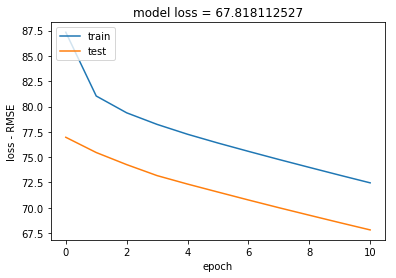

17731/17731 [==============================] - 57s 3ms/step - loss: 5251.1102 - val_loss: 4599.2964
Epoch 12/300


In [ ]:
ResNetCNN_2d.fit(X_train, Y_train, epochs = 300, batch_size = 2048, validation_data = (X_test, Y_test), callbacks=[plot_losses])

In [ ]:
#K.set_value(ResNetCNN_2d.optimizer.lr,0.0001)

In [ ]:
#ResNetCNN_2d.fit(X_train, Y_train, epochs = 10, batch_size = 2048, validation_data = (X_test, Y_test), callbacks=[plot_losses])

** Learning rate:**

In [ ]:
print('Learning Rate: ' + str(K.get_value(ResNetCNN_2d.optimizer.lr)))

Save the model (architecture, weights, ...) 

In [ ]:
ResNetCNN_2d.save('CNN_v6_ResNet_2Stg_2xC_3xI_tanh_Drop_0.5_NoBatch_Batch_2048.h5') 

# 4 Experimental Results

## 4.1 Performance Metrics
In this study, 2 metrics have been used for evaluating the performance of the proposed prognostic method, i.e. scoring function and root mean square error.

The scoring function used in this study has been proposed by many researchers and also employed by the International Conference on Prognostics and Health Management Data Challenge. 

where s denotes the score and N is the total number of testing data samples. di = RUL - RULi, that is the error between the estimated RUL value and the actual RUL value for the i-th testing data sample. The scoring function penalizes late prediction more than early prediction, that is because late prediction usually leads to more severe consequences in many
fields such as aerospace industries.

In [ ]:
def score_cal(y_hat, Y_test):
    d   = y_hat - Y_test
    tmp = np.zeros(d.shape[0])
    for i in range(d.shape[0]):
        if d[i,0] >= 0:
           tmp[i] = np.exp( d[i,0]/10) - 1
        else:
           tmp[i] = np.exp(-d[i,0]/13) - 1
    return tmp 

Another popular metric to evaluate the effectiveness of the proposed method is Root Mean Square Error (RMSE).

## 4.2 Training set

In [ ]:
preds = ResNetCNN_2d.evaluate(x = X_train, y = Y_train)
print()
print ("Test  MSE = " + str(preds))
print ("Test RMSE = " + str(np.sqrt(preds)))

In [ ]:
y_hat_tr   = ResNetCNN_2d.predict(x = X_train)
#score_i_tr = score_cal(y_hat_tr, Y_train)
#score_tr   = print("Score = " + str(sum(score_i_tr)))

### 4.2.1 Plots

In [ ]:
d_tr = y_hat_tr - Y_train
plt.hist(d_tr, bins='auto')  
plt.title('Error distribution - Training Set')
plt.ylabel('f')
plt.xlabel("Error: $RUL_{hat}$ - RUL")
plt.show()

## 4.3 Test set

In [ ]:
y_hat   = ResNetCNN_2d.predict(x = X_test)
#score_i = score_cal(y_hat, Y_test)
#score   = print("Score = " + str(sum(score_i)))

In [ ]:
preds = ResNetCNN_2d.evaluate(x = X_test, y = Y_test)
print()
print ("MSE = " + str(preds))
print ("RMSE = " + str(np.sqrt(preds)))

### 4.3.1 Plots

In [ ]:
d = y_hat - Y_test
plt.hist(d, bins='auto')  
plt.title('Error distribution - Test Set')
plt.ylabel('f')
plt.xlabel("Error: $RUL_{hat}$ - RUL")
plt.show()

In [ ]:
x     = range(0,100)
y_ts  = np.sort(Y_test[:,0])
idx   = np.argsort(Y_test[:,0])
y_tr  = y_hat[idx,0]
plt.plot(x, y_tr, 'bo-', x, y_ts, 'ro-')
plt.title('RUL vs. engine #')
plt.ylabel('RUL')
plt.xlabel('engine #')
plt.legend(['Prediction', 'Target'], loc='upper left')
plt.show()

In [ ]:
plt.plot(Y_test, y_hat, 'bo')
plt.plot(Y_test,Y_test, 'r-')
plt.plot(Y_test,Y_test+20, 'r--')
plt.plot(Y_test,Y_test-20, 'r--')
plt.title('RUL vs. RUL #')
plt.ylabel('RUL Estimated')
plt.xlabel('RUL True')
plt.show()

# 5 Conclusions

In [ ]:
K.tensorflow_backend._get_available_gpus()

In [ ]:
Y_test[Y_test > R_early] = R_early                     # R_early = 125 
preds = ResNetCNN_2d.evaluate(x = X_test, y = Y_test)
print()
print ("MSE = " + str(preds))
print ("RMSE = " + str(np.sqrt(preds)))

In [ ]:
x     = range(0,100)
y_ts  = np.sort(Y_test[:,0])
idx   = np.argsort(Y_test[:,0])
y_tr  = y_hat[idx,0]
plt.plot(x, y_tr, 'bo-', x, y_ts, 'ro-')
plt.title('RUL vs. engine #')
plt.ylabel('RUL')
plt.xlabel('Sorted engine #')
plt.legend(['Prediction', 'Target'], loc='upper left')
plt.show()

In [ ]:
plt.plot(Y_test, y_hat, 'bo')
plt.plot(Y_test,Y_test, 'r-')
plt.plot(Y_test,Y_test+20, 'r--')
plt.plot(Y_test,Y_test-20, 'r--')
plt.title('RUL vs. RUL #')
plt.ylabel('RUL Estimated')
plt.xlabel('RUL True')
plt.show()

In [ ]:
d = y_hat - Y_test
plt.hist(d, bins='auto')  
plt.title('Error distribution - Test Set')
plt.ylabel('f')
plt.xlabel("Error: $RUL_{hat}$ - RUL")
plt.show()

In [ ]:
max(Y_train)

In [ ]:
max(y_hat)

In [ ]:
plt.hist(Y_train, bins=20)  
plt.title('RUL distribution - Training Set')
plt.ylabel('f')
plt.xlabel("RUL")
plt.show()

In [ ]:
plt.hist(Y_test, bins=20)  
plt.title('RUL distribution - Test Set')
plt.ylabel('f')
plt.xlabel("RUL")
plt.show()

In [ ]:
plt.hist(y_hat, bins=20)  
plt.title('RUL distribution - Test Set')
plt.ylabel('f')
plt.xlabel("RUL")
plt.show()